## This file classifies road segments in a specific London neighbourhood by arbitrarily chosen road function and amenity type. It then visualizes the result

### Imports all necessary libraries and loads some data

In [11]:
#Processing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import FancyArrow
import matplotlib.lines as mlines
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import linemerge
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Image Processing
import os
from pathlib import Path
from PIL import Image

#Pytorch
import torch
from torchvision import transforms
from collections import Counter
from torchvision import models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


data_path = Path('London_UK')

panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
streets = gpd.read_file(data_path / 'network/edges/edges.geojson')

### Splits lineStrings (road sections) > 100m into segments < 50m. It then merges linestrings <10m into longer segments over 50m. This is done to standardize linestring lengths.

In [5]:
#Split large initial linestrings into segments <= 50m
def split_line(line, max_segment_length=50):
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    return [LineString([line.interpolate(i * segment_length), line.interpolate(min((i + 1) * segment_length, line.length))]) for i in range(num_segments)]

#Merge all linestrings < 10m until total length >= 50m
def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for line in streets_gdf['geometry']:
        if line.length < max_individual_length:
            current_merge.append(line)
            if sum(seg.length for seg in current_merge) >= min_total_length:
                merged_segments.append(linemerge(current_merge))
                current_merge = []
        else:
            if current_merge:
                merged_segments.append(linemerge(current_merge))
                current_merge = []
            merged_segments.append(line)

    if current_merge:
        merged_segments.append(linemerge(current_merge))

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)

if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=27700)  #Reprojection of coord ref system; 27700 is the most suited for our project location (London)

streets['length'] = streets.length

split_segments = [segment for _, row in streets.iterrows() for segment in (split_line(row['geometry'], max_segment_length=50) if row['length'] > 100 else [row['geometry']])]

split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)
split_streets_gdf_max['length'] = split_streets_gdf_max.length

merged_streets_gdf = merge_short_lines(split_streets_gdf_max)
merged_streets_gdf['length'] = merged_streets_gdf.length

### Categorizes the linestrings in length and makes a visualization

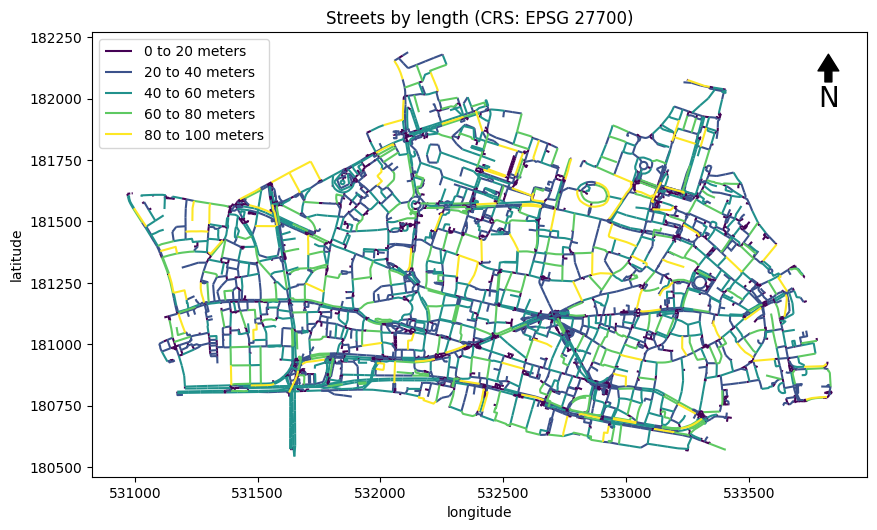

In [6]:
def add_north_arrow(ax, x=0.95, y=0.95, size=20, pad=0.1):
    ax.annotate('N', xy=(x, y), xytext=(x, y - pad),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=size, xycoords=ax.transAxes)

#Categorizes linestrings by length and plots them
def categorize_and_plot(gdf):
    bins = [0, 20, 40, 60, 80, 100]
    viridis = plt.colormaps['viridis']
    colors = [viridis(i / (len(bins) - 2)) for i in range(len(bins) - 1)]
    
    gdf['category'] = np.digitize(gdf['length'], bins, right=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, color in enumerate(colors, start=1):
        category_gdf = gdf[gdf['category'] == i]
        if not category_gdf.empty:
            category_gdf.plot(ax=ax, color=color, label=f'{bins[i-1]} to {bins[i]} meters')
    
    plt.title('Streets by length (CRS: EPSG 27700)')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.legend()
    add_north_arrow(ax)
    plt.show()

categorize_and_plot(merged_streets_gdf)

### Creates a buffer around each Linestring and performs spatial join to find which linestrings fall within the buffer. Visualizes the result.

C:\Users\lucia\AppData\Local\Temp\ipykernel_22736\160823734.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


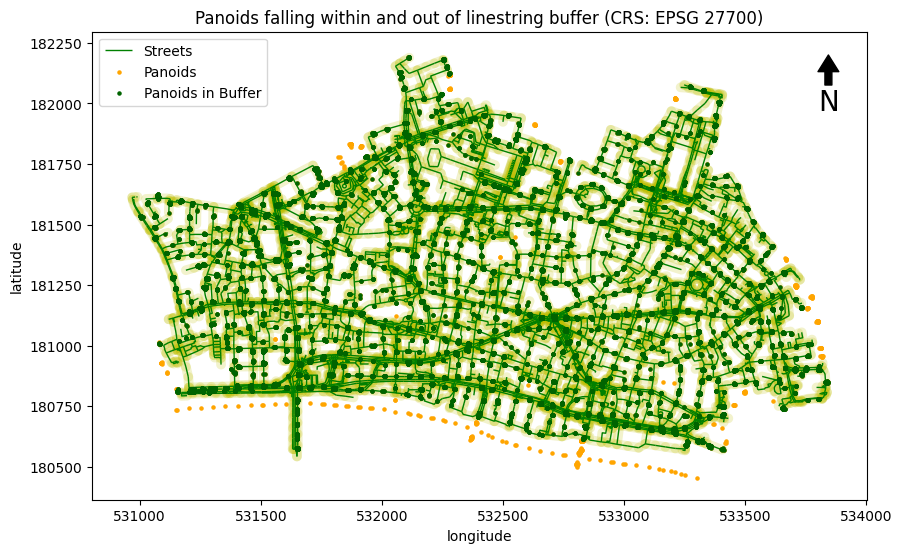

In [7]:
panoids_gdf = gpd.GeoDataFrame(
    panoids,
    geometry=gpd.points_from_xy(panoids['lng'], panoids['lat']),
    crs='EPSG:4326'  #WGS 84
)

if merged_streets_gdf.crs != panoids_gdf.crs:
    panoids_gdf = panoids_gdf.to_crs(merged_streets_gdf.crs)

if merged_streets_gdf.crs.is_geographic:
    merged_streets_gdf = merged_streets_gdf.to_crs(epsg=27700)

#Creates a buffer of 20 meters around each LineString
merged_streets_gdf['buffer'] = merged_streets_gdf.geometry.buffer(20)

#Perform a spatial join to find which panoids fall within the buffer
panoids_in_buffer = gpd.sjoin(panoids_gdf, merged_streets_gdf.set_geometry('buffer'), how='inner', predicate='within')

#Group by the index of the LineString and aggregate panoids
linestring_panoids = panoids_in_buffer.groupby('index_right')['panoid'].agg(list).reset_index()


fig, ax = plt.subplots(figsize=(10, 10))

merged_streets_gdf.plot(ax=ax, color='g', linewidth=1, label='Streets')
merged_streets_gdf.set_geometry('buffer').plot(ax=ax, color='y', alpha=0.2, label='Buffer (20m)')
panoids_gdf.plot(ax=ax, color='orange', markersize=5, label='Panoids')
panoids_in_buffer.plot(ax=ax, color='darkgreen', markersize=5, label='Panoids in Buffer', zorder=3)

plt.title('Panoids falling within and out of linestring buffer (CRS: EPSG 27700)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
add_north_arrow(ax)
plt.show()

### Maps each panoid to their linestring index via *linestring_panoids* dataframe

In [8]:
panoid_to_index = {panoid: index for index, panoid in enumerate(panoids['panoid'])}

def convert_panoid_to_index(panoid_list):
    return [panoid_to_index.get(panoid, -1) for panoid in panoid_list] #This solved an error we were getting

linestring_panoids.rename(columns={'index_right': 'linestring'}, inplace=True) #Renaming for conventionality
linestring_panoids['panoid_index'] = linestring_panoids['panoid'].apply(lambda x: [panoid_to_index.get(p, -1) for p in x])

#Showcasing dataframe
linestring_panoids

,linestring,panoid,panoid_index
0,5,[xdou9yN5jG9HVTpAHFIKNA],[4614]
1,6,"[Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]","[4608, 4614]"
2,8,[xdou9yN5jG9HVTpAHFIKNA],[4614]
3,9,"[xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...","[4591, 4593, 4594, 4595, 4597, 4599, 4600, 460..."
4,10,"[DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...","[4459, 4460, 4461, 4462, 4463, 4464, 4465, 446..."
...,...,...,...
4290,5025,"[VgB1-T_mMoImrsdbc9pAZA, ruQvGAcacOZK2SC3zwoKT...","[8872, 8873, 8874, 8875, 8876, 8877, 8878, 887..."
4291,5026,"[7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...","[9003, 9004, 9005, 9006, 9007, 9008, 9009, 901..."
4292,5027,"[7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...","[9003, 9004, 9005, 9006, 9007, 9008, 9009, 901..."
4293,5028,"[L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...","[8684, 8685, 8686, 8687, 8688, 8689, 8690, 869..."


### This calculates the mean and std tensor of the classified images in both the amenities and road function folder created in the trainer file. This has been done in the trainer file already, but doing it again ensures it is more generalizable to different datafiles/areas.

In [12]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Calculate mean and std for the roads dataset
dataset_road = ImageFolder(root='Classified_Images', transform=ToTensor())
loader_road = DataLoader(dataset_road, batch_size=64, shuffle=False)

mean_road = torch.zeros(3)
std_road = torch.zeros(3)

for images, _ in loader_road:
    batch_mean_road = torch.mean(images, dim=[0, 2, 3])
    batch_std_road = torch.std(images, dim=[0, 2, 3])
    mean_road += batch_mean_road
    std_road += batch_std_road

mean_road /= len(loader_road)
std_road /= len(loader_road)

# Calculate mean and std for the amenities dataset
dataset_amenities = ImageFolder(root='Classified_images_amenities', transform=ToTensor())
loader_amenities = DataLoader(dataset_amenities, batch_size=64, shuffle=False)

mean_amenities = torch.zeros(3)
std_amenities = torch.zeros(3)

for images, _ in loader_amenities:
    batch_mean_amenities = torch.mean(images, dim=[0, 2, 3])
    batch_std_amenities = torch.std(images, dim=[0, 2, 3])
    mean_amenities += batch_mean_amenities
    std_amenities += batch_std_amenities

mean_amenities /= len(loader_amenities)
std_amenities /= len(loader_amenities)

print(f"Roads dataset Mean: {mean_road}, Std: {std_road}")
print(f"Amenities dataset Mean: {mean_amenities}, Std: {std_amenities}")

# Assuming linestring_panoids is already defined
linestring_panoids_road = linestring_panoids  # We will use this dataframe to store the road images

Roads dataset Mean: tensor([0.4205, 0.4171, 0.4113]), Std: tensor([0.2165, 0.2145, 0.2206])
Amenities dataset Mean: tensor([0.4202, 0.4174, 0.4124]), Std: tensor([0.2137, 0.2127, 0.2190])


### 

## Road Classification

### Classifies streets based on the most common class prediction for each linestring. 

In [ ]:
transform_road = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_road, std=std_road),
])

def load_and_preprocess_image_road(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform_road(image)

def extract_feature_vector_road(image_tensor, model):
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
        vector = feature_extractor(image_tensor.unsqueeze(0))
    return vector.squeeze().numpy()

#This is the directory where the image database is located (~38000 images)
base_dir_road = 'D:\\School2(M)\\DSAIE\\STREET\\London_UK\\imagedb'

def generate_image_paths_road(panoid_index):
    return [
        f"{base_dir_road}/image_{panoid_index}_f.png",
        f"{base_dir_road}/image_{panoid_index}_b.png",
        f"{base_dir_road}/image_{panoid_index}_s_a.png",
        f"{base_dir_road}/image_{panoid_index}_s_b.png"
    ]

model_road = models.resnet34(pretrained=False)  #We already pretrained in the Trainer file but will include it to match model architecture
num_features_road = model_road.fc.in_features
model_road.fc = torch.nn.Linear(num_features_road, 3)  #3 Classes; main_road, residential_road, pedestrian_road (see below)
model_road.load_state_dict(torch.load("best_model_roads.pth"))  #Apply the roads model from the Trainer file
model_road.eval()

class_names_road = ['main_road', 'residential_road', 'pedestrian_road']

predictions_road = []

for idx, row in linestring_panoids_road.iterrows():
    index_right = row['linestring']
    panoid_indices = row['panoid_index']
    
    all_predictions = []

    for panoid_index in panoid_indices:
        image_paths = generate_image_paths_road(panoid_index)

        image_tensors = [load_and_preprocess_image_road(path) for path in image_paths if os.path.exists(path)]
        feature_vectors = [extract_feature_vector_road(tensor, model_road) for tensor in image_tensors]
        
        if not feature_vectors:
            continue
        
        average_vector = np.mean(feature_vectors, axis=0)
        average_vector_tensor = torch.tensor(average_vector).float().unsqueeze(0)

        with torch.no_grad():
            output = model_road.fc(average_vector_tensor)
            _, predicted = torch.max(output, 1)

        all_predictions.append(class_names_road[predicted.item()])

    #Assigns the most common class to each linestring (road segment)
    if all_predictions:
        most_common_class = Counter(all_predictions).most_common(1)[0][0]
        predictions_road.append(most_common_class)
    else:
        predictions_road.append(None)

#Add the predictions to the main dataframe
linestring_panoids_road['predicted_class'] = predictions_road

#Showcasing
print(linestring_panoids_road)

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\lucia\AppData\Local\Temp\ipykernel_22736\249567191.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight

### Merges *linestring_panoids_road* df with *merged_streets_gdf* gdf based on the linestring column.

In [103]:
csv_file_path = 'linestring_panoids_road.csv'
linestring_panoids_road.to_csv(csv_file_path, index=False)

#Merges geodataframe with the linestring_panoids_road dataframe
merged_gdf_road = merged_streets_gdf.merge(linestring_panoids_road, left_index=True, right_on='linestring', how='inner')

print(merged_gdf_road.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   geometry         4295 non-null   geometry
 1   length           4295 non-null   float64 
 2   category         4295 non-null   int64   
 3   buffer           4295 non-null   geometry
 4   linestring       4295 non-null   int64   
 5   panoid           4295 non-null   object  
 6   panoid_index     4295 non-null   object  
 7   predicted_class  44 non-null     object  
dtypes: float64(1), geometry(2), int64(2), object(3)
memory usage: 268.6+ KB
None


### Visualizes the London Neighbourhood with each road segment classified by road function 

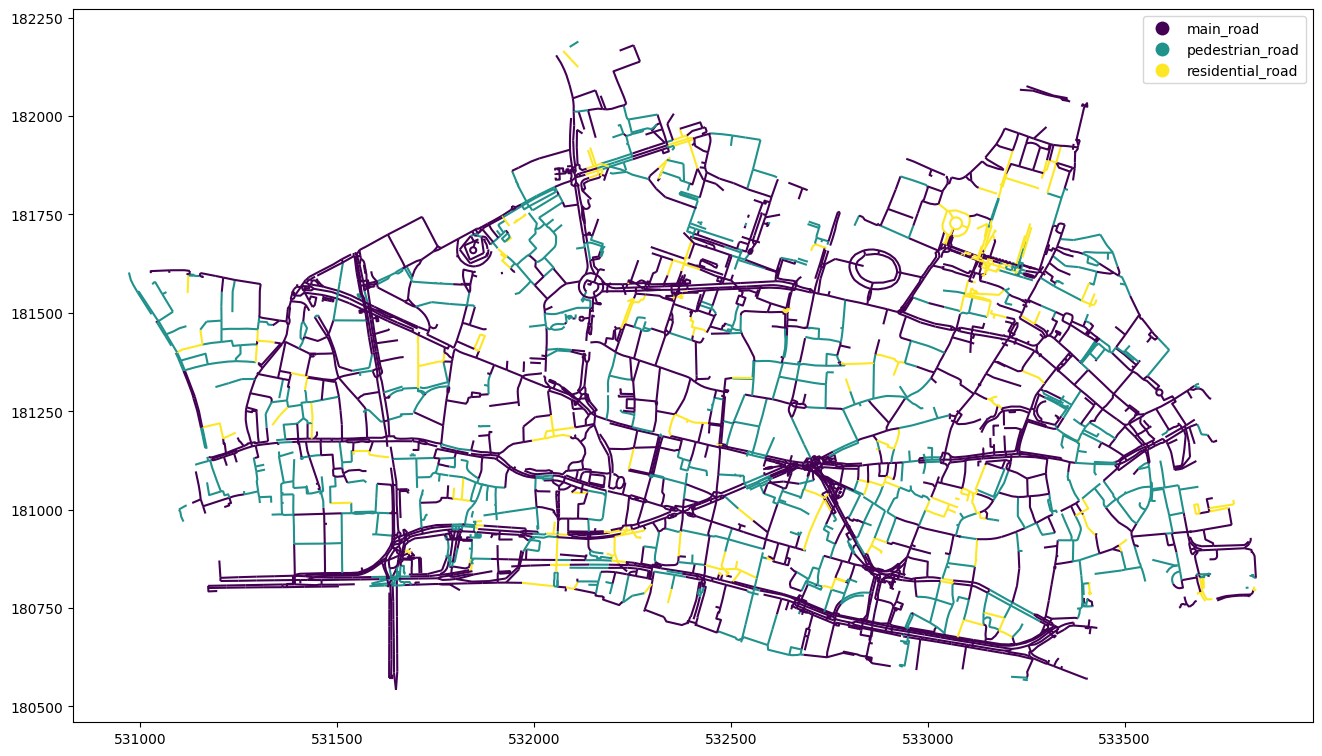

In [27]:
merged_gdf_road.plot(
    column='predicted_class', 
    legend=True, 
    cmap='viridis', 
    figsize=(16, 12)
)

plt.title('Road segments classified by type road function (CRS: EPSG 27700)')
plt.xlabel('longitude')
plt.ylabel('latitude')
add_north_arrow(plt.gca())
plt.show()

## Amenities Classification

In [22]:
#Copying the original linestring_panoids to apply the model on it
linestring_panoids_amenities = linestring_panoids

### Classifies streets based on the most common class prediction for each linestring. 

In [15]:
transform_amenities = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_amenities, std=std_amenities),
])

def load_and_preprocess_image_amenities(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform_amenities(image)

def extract_feature_vector_amenities(image_tensor, model):
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
        vector = feature_extractor(image_tensor.unsqueeze(0))
    return vector.squeeze().numpy()

base_dir_amenities = 'D:\\School2(M)\\DSAIE\\STREET\\London_UK\\imagedb'

def generate_image_paths_amenities(panoid_index):
    return [
        f"{base_dir_amenities}/image_{panoid_index}_f.png",
        f"{base_dir_amenities}/image_{panoid_index}_b.png",
        f"{base_dir_amenities}/image_{panoid_index}_s_a.png",
        f"{base_dir_amenities}/image_{panoid_index}_s_b.png"
    ]

model_amenities = models.resnet34(pretrained=False)
num_features_amenities = model_amenities.fc.in_features
model_amenities.fc = torch.nn.Linear(num_features_amenities, 15)  #15 amenity classes
model_amenities.load_state_dict(torch.load("best_model_amenities.pth"))
model_amenities.eval()

class_names_amenities = [
    "Bridge",
    "Education and Learning Spaces",
    "Entertainment and Cultural Spaces",
    "Financial and Administrative Services",
    "Food and Beverage",
    "Food Beverage",
    "Greenery",
    "Infrastructure of interest",
    "Pedestrian",
    "Public Amenities",
    "Public and Government Buildings",
    "Public Services and Utilities",
    "Residential buildings",
    "Retail and Commercial Services",
    "Transportation and Mobility"
]

predictions_amenities = []

for idx, row in linestring_panoids_amenities.iterrows():
    index_right = row['index_right']
    panoid_indices = row['panoid_index']
    
    all_predictions = []

    for panoid_index in panoid_indices:
        image_paths = generate_image_paths_amenities(panoid_index)

        image_tensors = [load_and_preprocess_image_amenities(path) for path in image_paths if os.path.exists(path)]
        feature_vectors = [extract_feature_vector_amenities(tensor, model_amenities) for tensor in image_tensors]
        
        if not feature_vectors:
            continue
        
        average_vector = np.mean(feature_vectors, axis=0)
        average_vector_tensor = torch.tensor(average_vector).float().unsqueeze(0)

        with torch.no_grad():
            output = model_amenities.fc(average_vector_tensor)
            _, predicted = torch.max(output, 1)

        all_predictions.append(class_names_amenities[predicted.item()])

    if all_predictions:
        most_common_class = Counter(all_predictions).most_common(1)[0][0]
        predictions_amenities.append(most_common_class)
    else:
        predictions_amenities.append(None)

linestring_panoids_amenities['predicted_class'] = predictions_amenities

linestring_panoids_amenities

C:\Users\fmaca\AppData\Local\Temp\ipykernel_17548\2463619653.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_ammenities.pth

      index_right                                             panoid  \
0               5                           [xdou9yN5jG9HVTpAHFIKNA]   
1               6   [Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]   
2               8                           [xdou9yN5jG9HVTpAHFIKNA]   
3               9  [xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...   
4              10  [DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...   
...           ...                                                ...   
4290         5025  [VgB1-T_mMoImrsdbc9pAZA, ruQvGAcacOZK2SC3zwoKT...   
4291         5026  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4292         5027  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4293         5028  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   
4294         5030  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   

                                           panoid_index    predicted_class  
0                                                [4614]   

### Merges *linestring_panoids_amenities* df with *merged_streets_gdf* gdf based on the linestring column.

In [16]:
csv_file_path = 'linestring_panoids_amenities.csv'
linestring_panoids_amenities.to_csv(csv_file_path, index=False)

In [21]:
#Merges geodataframe with the linestring_panoids_amenities dataframe
merged_gdf_amenities = merged_streets_gdf.merge(linestring_panoids_amenities, left_index=True, right_on='index_right', how='inner')

merged_gdf_amenities.head()


,geometry,length,category,buffer,index_right,panoid,panoid_index,predicted_class
0,"LINESTRING (532951.266 180658.423, 532941.347 ...",77.473542,4,"POLYGON ((532917.511 180587.653, 532916.704 18...",5,[xdou9yN5jG9HVTpAHFIKNA],[4614],River
1,"LINESTRING (532981.203 180671.091, 532971.003 ...",79.244202,4,"POLYGON ((532990.837 180589.932, 532990.489 18...",6,"[Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]","[4608, 4614]",Food and Beverage
2,"LINESTRING (532929.998 180666.88, 532935.482 1...",36.221878,2,"POLYGON ((532926.223 180647.245, 532924.414 18...",8,[xdou9yN5jG9HVTpAHFIKNA],[4614],River
3,"MULTILINESTRING ((532981.203 180671.091, 53298...",12.402918,1,"POLYGON ((533005.896 180667.25, 533005.896 180...",9,"[xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...","[4591, 4593, 4594, 4595, 4597, 4599, 4600, 460...",Food and Beverage
4,"LINESTRING (533097.397 180651.966, 533097.023 ...",58.420169,3,"POLYGON ((533116.789 180646.492, 533116.784 18...",10,"[DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...","[4459, 4460, 4461, 4462, 4463, 4464, 4465, 446...",River


### Visualizes the neighbourhood of London with all road segments classified by amenity

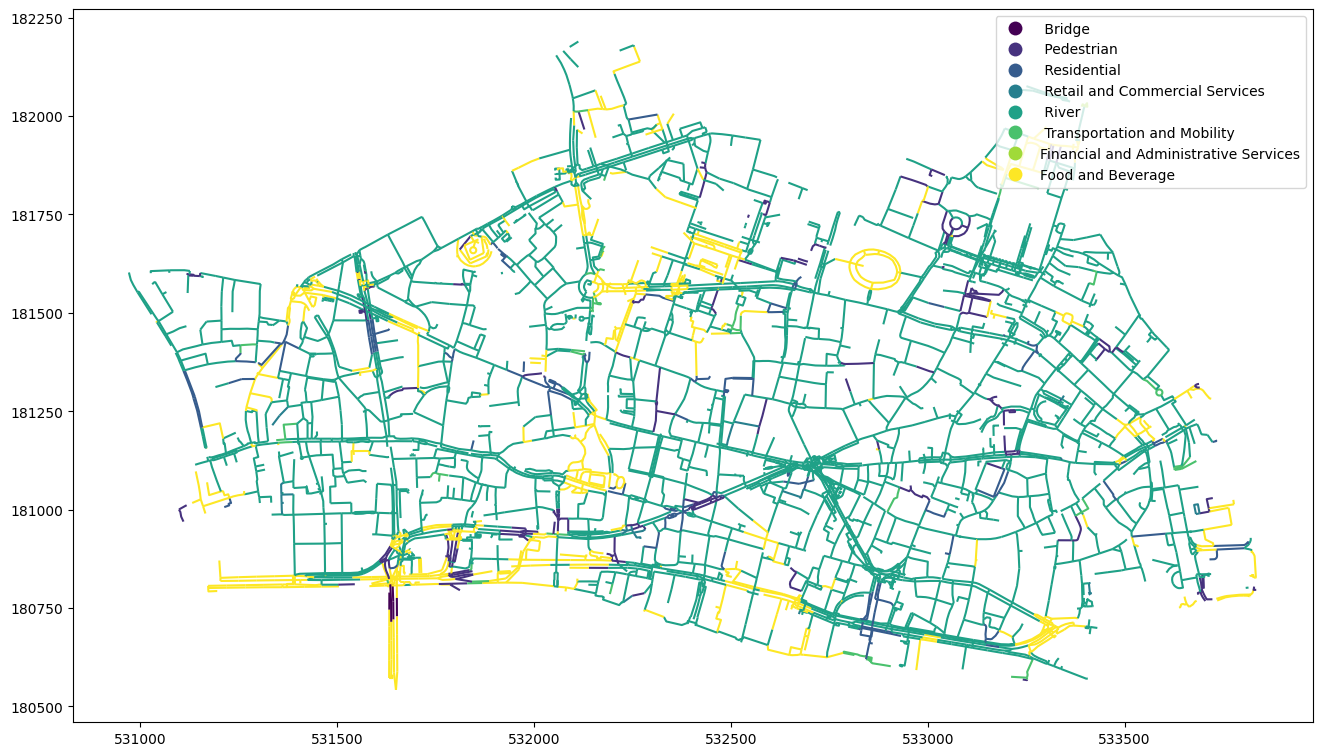

In [19]:
merged_gdf_amenities.plot(
    column='predicted_class', 
    legend=True, 
    cmap='viridis', 
    figsize=(16, 12)
)

plt.title('Road segments classified by type amenity type (CRS: EPSG 27700)')
plt.xlabel('longitude')
plt.ylabel('latitude')
add_north_arrow(plt.gca())
plt.show()

### Evaluates model on test dataset defined in the Trainer file and visualizes the performance

In [ ]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model_road, test_loader_road, class_names_road)

plot_confusion_matrix(model_amenities, test_loader_amenities, class_names_amenities)